In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### EDA

In [2]:
df_train = pd.read_csv("data/train.csv",index_col='id')
df_test = pd.read_csv("data/test.csv",index_col='id')


In [3]:
df_train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


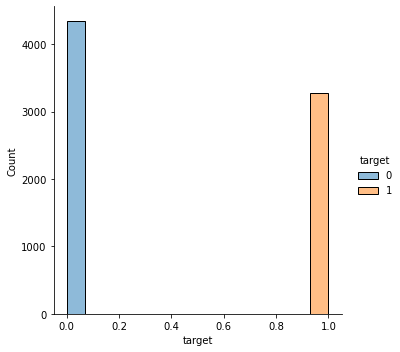

In [4]:
sns.displot(data=df_train, x='target', hue='target')

<AxesSubplot:>

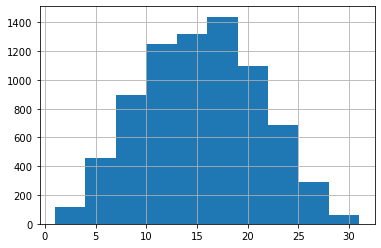

In [5]:
df_train['length'] =  df_train['text'].apply(lambda x: len(x.split())).values
df_train['length'].hist()

### Data Cleaning

In [9]:
import string, re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /home/tkindvall/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tkindvall/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def clean_text(t):
    t  = "".join([char for char in t if char not in string.punctuation])
    t = re.sub('[0-9]+', '', t)
    
    t = t.lower() # lowercase
    
    t = t.replace(r"\#","",True) # replaces hashtags
    t = t.replace(r"http\S+","URL", True )  # remove URL addresses
    t = t.replace(r"@","",  True )
    t = t.replace("\s{2,}", " ", True ) # remove multiple contiguous spaces
    return t


In [12]:
df_train['text'] = df_train['text'].apply(lambda t: clean_text(t))
df_test['text'] = df_test['text'].apply(lambda t: clean_text(t))
 
#df_train_clean.head()

### Model Architecture
#### LTSM and Gated Recurrent Unit

In this lesson we will use LTSM and  Gradient Recurrent Units to train models. Both LTSM and GRU are types of RRN's. We will start by downloading and using some pre made embedings then train models on top of the embedings. These embeddings have had a hight amount of training behind them already, training on a scale that I couldn't acheive on my own. So this gives us a headstart for training our models.

In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text 
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Embedding, Dropout
from tensorflow.keras.layers import TextVectorization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

2024-03-08 17:27:21.827539: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 17:27:22.307256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 17:27:22.307408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 17:27:22.372958: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 17:27:22.541057: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 17:27:22.549496: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(
    df_train['text'].values,
    df_train['target'].values,
    shuffle=True,
    test_size=0.2)

In [15]:
max_text_len = max(df_train['text'].apply(lambda x: len(x.split())).values) # we know this from the EDA
max_words = 50000
tokenizer = text.Tokenizer(num_words = max_words)

tokenizer.fit_on_texts(xtrain) #fit tokens on training data

xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)

In [16]:
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_text_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_text_len)
word_index = tokenizer.word_index
 
print('text example:', xtrain[0])
print('sequence of indices(before padding):', xtrain_seq[0])
print('sequence of indices(after padding):', xtrain_pad[0])

text example: the hobbit the desolation of smaug  ed sheeran i see fire hd httptcooxrwrjzmnu
sequence of indices(before padding): [1, 1415, 1, 487, 5, 1217, 2902, 3761, 7, 114, 40, 2347, 5707]
sequence of indices(after padding): [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    1 1415    1  487    5 1217 2902 3761    7  114
   40 2347 5707]


In [ ]:
#Run on first time only

#https://nlp.stanford.edu/projects/glove/
#!wget https://nlp.stanford.edu/data/glove.6B.zip
#!unzip g*zip

In [18]:
%%time
embedding_vectors = {}
with open('glove.6B.300d.txt','r',encoding='utf-8') as file: #glove.42B.300d.txt
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")

Size of vocabulary in GloVe: 400000
CPU times: user 19.9 s, sys: 6.31 s, total: 26.2 s
Wall time: 26.2 s


In [19]:
emb_dim = 300
vocab_len = max_words if max_words is not None else len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')
print(f'{oov_count} out of {vocab_len} words were OOV.')

Some out of valubulary words: ['\x89û', '\x89ûò', 're\x89û', 'yearold', 'typhoondevastated']
8059 out of 50000 words were OOV.


In [20]:
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
                              
                              
callbacks_list = [reducel, earlystopper]

In [21]:
def plot_model_acc(model_history):
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.figure()

After seting up some general model stuructre above I create and train an LSTM model.

In [22]:
model_lstm = Sequential(name='model_lstm')
model_lstm.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
#model_lstm.add(Embedding(vocab_len, emb_dim, trainable = True))
model_lstm.add(LSTM(64, activation='tanh', return_sequences=False))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(tf.keras.layers.BatchNormalization())
model_lstm.add(Dropout(0.2)) # Adding Dropout layer with rate of 0.2
model_lstm.add(Dense(256, activation='relu'))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
model_lstm.summary()

2024-03-08 17:28:53.217237: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 60000000 exceeds 10% of free system memory.
2024-03-08 17:28:53.263367: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 60000000 exceeds 10% of free system memory.
2024-03-08 17:28:53.314626: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 60000000 exceeds 10% of free system memory.
2024-03-08 17:28:53.659213: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 60000000 exceeds 10% of free system memory.


Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         15000000  
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                        

In [23]:
%%time
batch_size = 32
epochs  = 20
history_lstm = model_lstm.fit(xtrain_pad,
    np.asarray(ytrain),
    validation_data=(xtest_pad, np.asarray(ytest)),
    batch_size = batch_size,
    epochs = epochs,
    callbacks = callbacks_list)

Epoch 1/20
190/191 [============================>.] - ETA: 0s - loss: 0.5000 - accuracy: 0.7630 - recall: 0.6338 - auc: 0.8229

2024-03-08 17:29:03.341443: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 60000000 exceeds 10% of free system memory.


191/191 [==============================] - 9s 33ms/step - loss: 0.4998 - accuracy: 0.7631 - recall: 0.6343 - auc: 0.8232 - val_loss: 0.5439 - val_accuracy: 0.7774 - val_recall: 0.8441 - val_auc: 0.8747 - lr: 0.0010
Epoch 2/20
191/191 [==============================] - 6s 29ms/step - loss: 0.4247 - accuracy: 0.8138 - recall: 0.7018 - auc: 0.8739 - val_loss: 0.5053 - val_accuracy: 0.7971 - val_recall: 0.5764 - val_auc: 0.8629 - lr: 0.0010
Epoch 3/20
191/191 [==============================] - 5s 27ms/step - loss: 0.3908 - accuracy: 0.8281 - recall: 0.7238 - auc: 0.8955 - val_loss: 0.4382 - val_accuracy: 0.8037 - val_recall: 0.6252 - val_auc: 0.8700 - lr: 0.0010
Epoch 4/20
191/191 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8491 - recall: 0.7568 - auc: 0.9143
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
191/191 [==============================] - 5s 25ms/step - loss: 0.3517 - accuracy: 0.8491 - recall: 0.7568 - auc: 0.9143 - val_lo

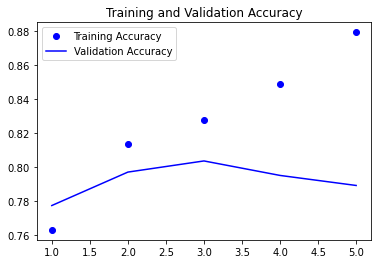

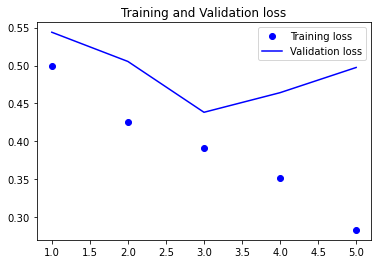

<Figure size 432x288 with 0 Axes>

In [24]:
plot_model_acc(history_lstm)

Here we see that the preformance of the LTSM is not great. I played arround with many differnet setting and optimisers but this was the best performance I was able to acheive with the LSTM.

I am now going to use the slightly different archtechure of GRU's to hopefully have better preformance.

In [25]:
emb_dim = embedding_matrix.shape[1]
model_gru = Sequential(name='model_gru')
model_gru.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
model_gru.add(GRU(128, return_sequences=False))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1, activation = 'sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

Model: "model_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         15000000  
                                                                 
 gru (GRU)                   (None, 128)               165120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15165249 (57.85 MB)
Trainable params: 165249 (645.50 KB)
Non-trainable params: 15000000 (57.22 MB)
_________________________________________________________________


Epoch 1/20
191/191 [==============================] - 9s 39ms/step - loss: 0.4933 - accuracy: 0.7637 - val_loss: 0.4226 - val_accuracy: 0.8122 - lr: 0.0010
Epoch 2/20
191/191 [==============================] - ETA: 0s - loss: 0.4206 - accuracy: 0.8215
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
191/191 [==============================] - 7s 35ms/step - loss: 0.4206 - accuracy: 0.8215 - val_loss: 0.4307 - val_accuracy: 0.8096 - lr: 0.0010
Epoch 3/20
191/191 [==============================] - 7s 35ms/step - loss: 0.3754 - accuracy: 0.8438 - val_loss: 0.4090 - val_accuracy: 0.8155 - lr: 1.0000e-04
Epoch 4/20
191/191 [==============================] - ETA: 0s - loss: 0.3639 - accuracy: 0.8463
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
191/191 [==============================] - 7s 35ms/step - loss: 0.3639 - accuracy: 0.8463 - val_loss: 0.4111 - val_accuracy: 0.8168 - lr: 1.0000e-04
Epoch 5/20
191/191 [========================

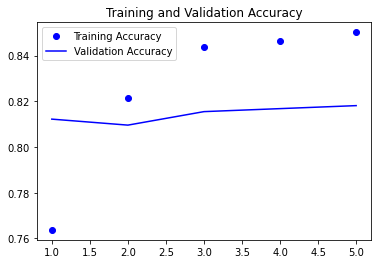

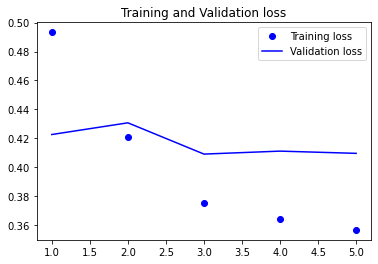

<Figure size 432x288 with 0 Axes>

In [26]:
batch_size = 32
epochs  = 20
history_gru = model_gru.fit(xtrain_pad,
                         np.asarray(ytrain),
                         validation_data=(xtest_pad, np.asarray(ytest)),
                         batch_size = batch_size,
                         epochs = epochs,
                         callbacks = callbacks_list)

plot_model_acc(history_gru)

## Results and Analysis
After some tinkering with the setting and number of layers I finaly ended with this model. While this isnt superb performance it is much better than LTSM so this is what I will use for my submission. 81% accuarcy on the validation set is a solid preformance. especially since I am training my a laptop without dedicated graphics. If I had more computational power I would probably look to do more instensive layers and modeling.

## Conclusion
GRU models are better for this dataset than LTSM models. While this should be expected as GRU models have been replacing LTSM models for many NLP problems it is good to see that the results are consistent and work well. In the future I would hope to have a cluster of GPU's that would allow for more layers and epochs to be ran at the same time. This increase in computational power would certainly improve my results. 

#### Generating submission

In [33]:
X_test= df_test['text'].values
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_text_len)
predictions_prob = model_gru.predict(X_test_pad)
predictions = tf.round(predictions_prob)
#print(predictions)

print(df_test.columns)
df_out = pd.DataFrame()
df_out.index = df_test.index
df_out['target'] = predictions
df_out = df_out.astype({"target": int})
df_out.to_csv('submission.csv')


102/102 [==============================] - 1s 11ms/step
Index(['keyword', 'location', 'text'], dtype='object')
